# ВШЭ Семинар 3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC, NuSVC
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (LinearSVC или же SVC(kernel='linear') в sklearn.svm). Подберите параметр регуляризации C (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

In [12]:
clf = SVC(kernel='linear',C=1,probability= True).fit(X_train,y_train)

На тестовой части посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Постройте ROC и PR кривые, сравните их с ответами случайного классификатора. Заметим, что с помощью sklearn можно посчитать обе метрики двумя разными способами - в чем их различия? Сравните результаты.

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc, plot_precision_recall_curve
from sklearn.metrics import average_precision_score, precision_recall_curve
y_score = clf.predict(X_test)
print(roc_auc_score(y_test, y_score))
yhat = clf.predict_proba(X_test)
pos_probs = yhat[:, 1]
# precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

0.7751382288658409
PR AUC: 0.815


На тестовой части посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Постройте ROC и PR кривые, сравните их с ответами случайного классификатора. Заметим, что с помощью sklearn можно посчитать обе метрики двумя разными способами - в чем их различия? Сравните результаты.

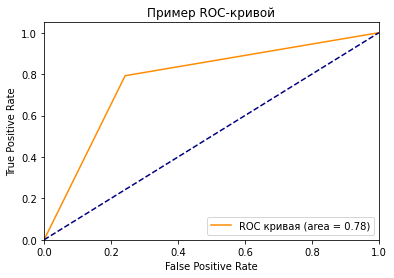

In [16]:
roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr')
fpr, tpr, treshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

0.8311566029589885


C:\Users\Лавандос\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Binary class Precision-Recall curve: AP=0.71')

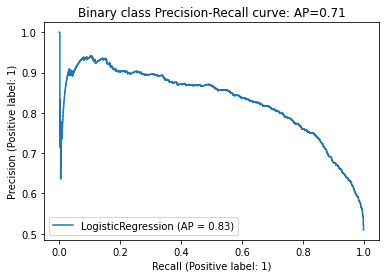

In [17]:
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression(penalty="l2")
clf_log.fit(X_train, y_train)
y_score = clf_log.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
average_precision = average_precision_score(y_test, y_score)
disp = plot_precision_recall_curve(clf_log, X_test, y_test)
disp.ax_.set_title('Binary class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок  на несколько маленьких отрезков одинаковой длины. Рассмотрим -й отрезок с границами 
 и предсказания 
, которые попали в него. Пусть им соответствуют истинные ответы 
. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно 
 единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [18]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l - r) / 2) 
        bin_real_ratios.append(np.min(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Воспользуйтесь CalibratedClassifierCV из sklearn для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

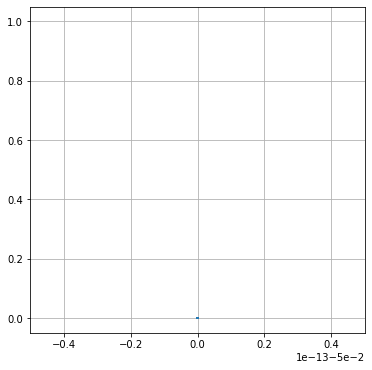

In [19]:
from sklearn.calibration import CalibratedClassifierCV
clf_cal = CalibratedClassifierCV(base_estimator=clf_log, cv= 3)
clf_cal.fit(X_test, y_test)
y_socre = clf_cal.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, y_socre)


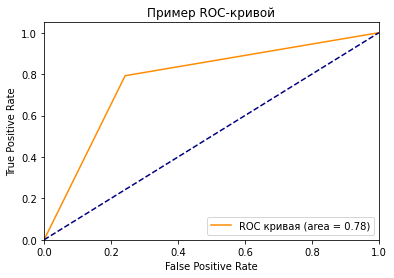

In [23]:
roc_auc_score(y_test, clf_log.predict(X_test), multi_class='ovr')
fpr, tpr, treshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

In [24]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0,
    random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью make_classification с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут support_vectors_). В этот раз, если необходимо, вместо LinearSVC воспользуйтесь SVC(kernel='linear'), так как только в нём есть информация об опорных векторах.

In [25]:
clf = SVC(kernel='linear',C=1).fit(X_train,y_train)
clf.support_vectors_

array([[ 1.01355564, -0.41963808],
       [-1.34456334,  0.25414983],
       [ 1.32704558, -0.31936361],
       ...,
       [ 0.05528074, -0.04778752],
       [ 0.584125  , -0.1247789 ],
       [-1.16333013,  0.79249276]])

In [26]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

Загрузим данные UCI Bank Marketing Dataset. Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле bank-additional-names.txt.

In [58]:

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте random_state=777, также используйте stratify. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его.

Закодируйте категориальные признаки с помощью OrdinalEncoder. Посчитайте качество (в этом задании будем работать c AUC-PR) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

In [68]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
#кодируем кат. признаки 
df_temp = df
for c in df_temp:
     df_temp[c] = OrdinalEncoder().fit_transform(df_temp[c].astype(str).values.reshape(-1, 1))
#дропаем таргет из обучающей и запоминаем в y
X = df_temp.drop(['y'], axis = 1)
y = df_temp['y']
#сплитим
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify =y)
#создаём модель
clf_log_2 = LogisticRegression()
#обучаем
clf_log_2.fit(X_train, y_train)
#Предсказываем
y_score = clf_log_2.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
#AUC PR
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)


0.4059009480684739


C:\Users\Лавандос\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
